In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torchvision.io import read_image
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from torch import optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
seed = 99

Using cpu device


In [5]:
## Define custom dataset
class CustomDatasetFromCSV(Dataset):
    def __init__(self, csv_path, height, width,status,transforms=None):      
        self.data = pd.read_csv(csv_path)
        self.labels = np.asarray(self.data.iloc[:, 0])
        self.height = height
        self.width = width
        self.transforms = transforms
        self.status = status

    def __getitem__(self, index):
        single_image_label = self.labels[index]        
        img_as_np = np.asarray(self.data.iloc[index][self.status:]).reshape(28,28).astype('uint8')	
        img_as_img = Image.fromarray(img_as_np)
        
        #transform image to tensor
        img_as_img = img_as_img.convert('L')    
        if self.transforms is not None:
            img_as_tensor = self.transforms(img_as_img)       
        return (img_as_tensor, single_image_label)

    def __len__(self):
        return len(self.data.index)

In [6]:
## Create custom dataset
transformations = transforms.Compose([transforms.ToTensor()])
imageData = CustomDatasetFromCSV('./train.csv',784,784,1,transformations)
testData = CustomDatasetFromCSV('./test.csv',784,784,0,transformations)

In [7]:
trainData,validationData=train_test_split(imageData,train_size=0.9,random_state=seed)
train_loader = DataLoader(trainData, batch_size = 20)
validation_loader = DataLoader(validationData,batch_size=20)
test_loader = DataLoader(testData,batch_size=20)


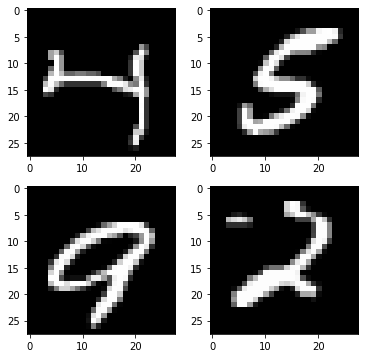

In [8]:
vis_data_normal=next(iter(train_loader))
fig, ax = plt.subplots(2, 2, figsize = (6, 6))
for j in range(0,2):
    for i in range(0,2):
        # ax[i, j].set_title("Label: " + str(vis_data_normal[1][i+(j*2)]), color="red") 
        ax[i, j].imshow(np.squeeze(vis_data_normal[0][i+(j*2)]), cmap='gray')



In [9]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 4 * 4, 120)  # 4*4 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
model = NeuralNetwork().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),0.0005)
total_step = len(train_loader)
epoch = 20
model.train()
for t in range(epoch):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 2.305295  [    0/37800]
loss: 1.241775  [ 2000/37800]
loss: 0.612065  [ 4000/37800]
loss: 0.812499  [ 6000/37800]
loss: 0.245854  [ 8000/37800]
loss: 0.273763  [10000/37800]
loss: 0.210973  [12000/37800]
loss: 0.345184  [14000/37800]
loss: 0.325439  [16000/37800]
loss: 0.226677  [18000/37800]
loss: 0.038577  [20000/37800]
loss: 0.209177  [22000/37800]
loss: 0.069222  [24000/37800]
loss: 0.047920  [26000/37800]
loss: 0.148361  [28000/37800]
loss: 0.034345  [30000/37800]
loss: 0.135511  [32000/37800]
loss: 0.013564  [34000/37800]
loss: 0.084852  [36000/37800]
Test Error: 
 Accuracy: 9.9%, Avg loss: 10.539463 

Epoch 2
-------------------------------
loss: 0.038130  [    0/37800]
loss: 0.192439  [ 2000/37800]
loss: 0.233338  [ 4000/37800]
loss: 0.200042  [ 6000/37800]
loss: 0.146252  [ 8000/37800]
loss: 0.063859  [10000/37800]
loss: 0.028124  [12000/37800]
loss: 0.089303  [14000/37800]
loss: 0.094492  [16000/37800]
loss: 0.100090  [18000/37800

KeyboardInterrupt: 

In [ ]:
result=pd.DataFrame(columns=['ImageId','Label'])
serial=[]
ans=[]
model.eval()
for s,i in enumerate(test_loader):
    serial.append(s+1)
    ans.append(((model(i.to(device))).argmax()).to(device))
result['ImageId']=serial    
result['Label']=np.array(ans)
result.to_csv("result.csv",index=False)
result